In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 12}

plt.rc('font', **font)

import fair
fair.__version__

'1.0.1'

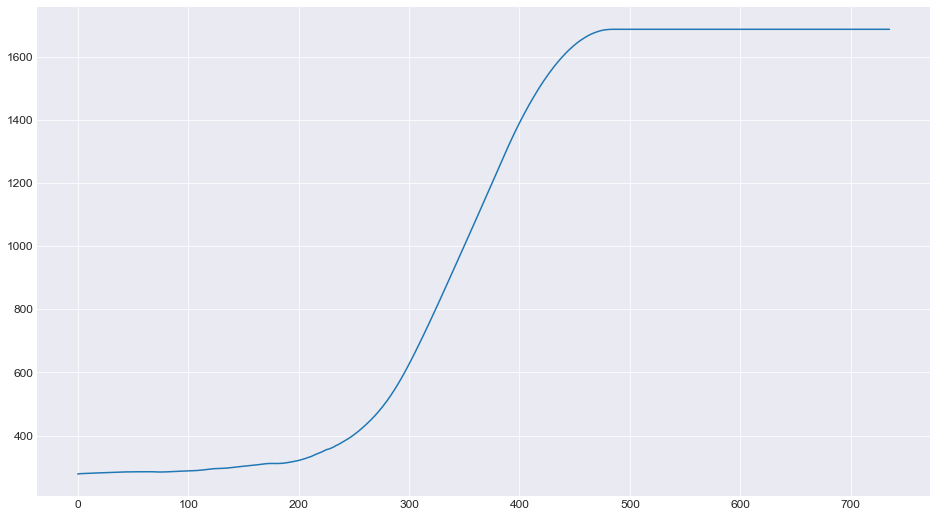

In [57]:
import numpy as np

from scipy.optimize import fsolve as do_it

M_0 = 722.0
C_0 = 278.0
N_0 = 270.0
a1=-2.4*10**(-7)
b1=7.2*10**(-4)
c1=-2.1*10**(-4)
K1=5.36
a2=-8.0*10**(-6)
b2=4.2*10**(-6)
c2=-4.9*10**(-6)
K2=0.117
a3=-1.3*10**(-6)
b3=-8.2*10**(-6)
K3=0.043


forc_file = './fair/RCPs/RCP85_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)

RF_M = forc_data['CH4_RF']
RF_N = forc_data['N2O_RF']
RF_C = forc_data['CO2_RF']

ans = np.zeros([len(RF_M),3])
for i in np.arange(len(RF_M)):

    def func(x):
    
        [M,N,C] = x
        
        b = np.zeros(3)
        b[0] = (a3*np.mean([M,M_0]) + b3*np.mean([N,N_0]) + K3) * (np.sqrt(M) - np.sqrt(M_0)) - RF_M[i]
        b[1]= (a2*np.mean([C,C_0]) + b2*np.mean([N,N_0]) + c2*np.mean([M,M_0]) + K2) * (np.sqrt(N) - np.sqrt(N_0)) - RF_N[i]
        b[2]= (a1*(C-C_0)**(2) + b1*abs(C-C_0) + c1*np.mean([N,N_0]) + K1) * np.log(C/C_0) - RF_C[i]
        return b

    ans[i] = do_it(func , [1500.0,300.0,400.0])


ans = np.swapaxes(ans,0,1)
plt.plot(ans[2])

C:\Users\leach_000\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:14: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



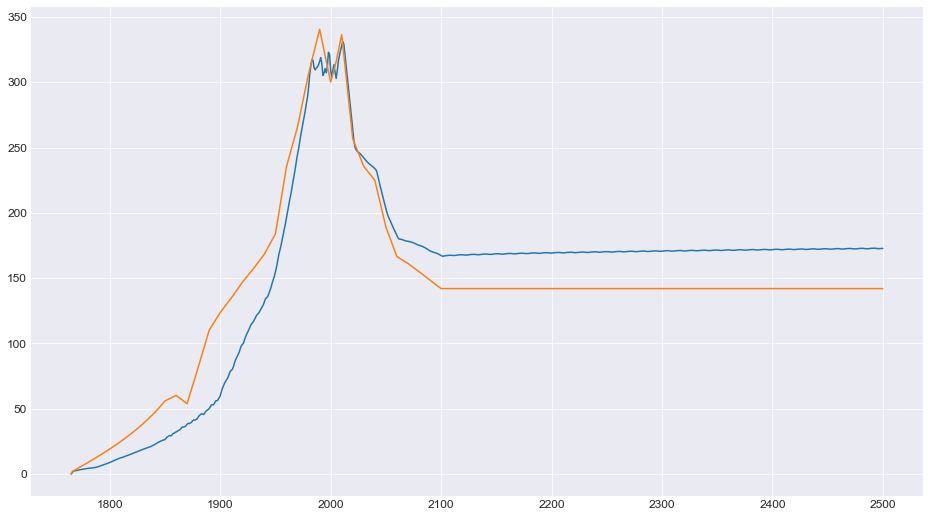

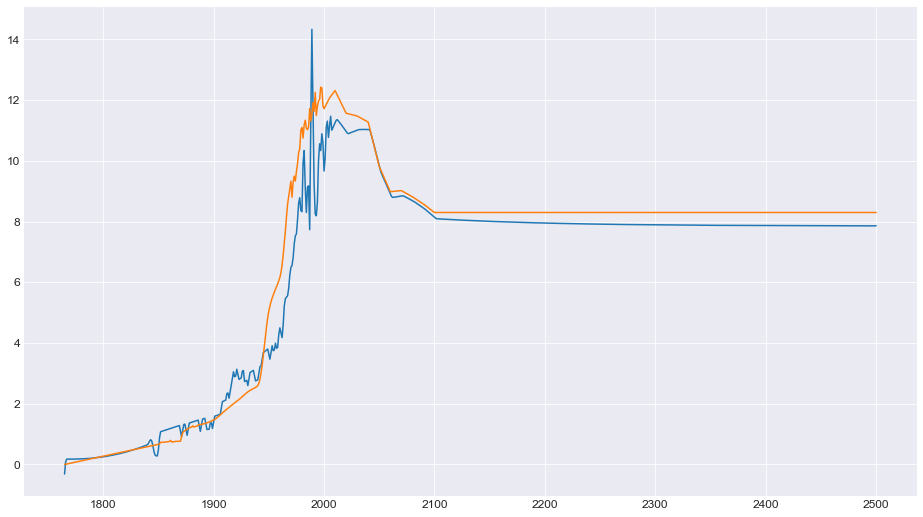

In [23]:
# Inverting N2O / CH4

forc_file = './fair/RCPs/RCP3PD_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
emms_file = './fair/RCPs/RCP3PD_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)
N_emissions = emms_data['N2O'] * 44.0 / 28.0 # convert to MtN2O from MtN2O-N
emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']

other_rf = forc_data['TOTAL_INCLVOLCANIC_RF'] #- forc_data['N2O_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF']

C,T,RF,M,N,MK_gas,db,tau = fair.forward.fair_scm(other_rf=other_rf, M_0= 721.89411, N_0 = 273.0,
                                                 tau_N=121.0,nN = 0.007)

concs_file = './fair/GCP_data/RCP3PD_MIDYEAR_CONCENTRATIONS.csv'
concs_data = np.genfromtxt(concs_file,skip_header=37,delimiter=',',names=True)
M_concs = concs_data['CH4']
N_concs = concs_data['N2O']

def N_emissions_calc(N , N_0=273.0, tau_N=121.0, N_pre=0.0,nN=0.007,tstep = 1):
    
    E = np.zeros(len(N))
    
    E[0] = (N[0] - N_0 + nN * (N_pre) - (N_pre)*np.exp(-tstep/tau_N)) / (tau_N * (1 - np.exp(-tstep/tau_N)))
    
    for i,x in enumerate(N[1:],1):
        E[i] = (x - N_0 + nN*(N[i-1]-N_0) - (N[i-1] - N_0)*np.exp(-tstep/tau_N)) / (tau_N * (1 - np.exp(-tstep/tau_N)))
        
    return E * 7.787

def M_emissions_calc(M,T,M_0=722.0,M_pre=-0.10589,T_pre=0.0,tstep = 1,m0 = 11,mM = 0.00045,mT = -0.002):
    
    E = np.zeros(len(M))
    
    tau_M_OH = np.zeros(len(M))
    tau_M = np.zeros(len(M))
    
    tau_M_OH[0] = m0 + mM * (M_pre) + mT * T_pre
    
    tau_M_OH[1:] = m0 + mM * (M[:-1]-M_0) + mT * T[:-1]
    
    tau_M = (1/tau_M_OH + 1/120.0 + 1/150.0 + 1/200.0)**(-1)

    E[0] = (M[0] - M_0 - (M_pre)*np.exp(-tstep/tau_M[0])) / (tau_M[0] * (1 - np.exp(-tstep/tau_M[0])))
    
    for i,x in enumerate(M[1:],1):
        E[i] = (x - M_0 - (M[i-1] - M_0)*np.exp(-tstep/tau_M[i])) / (tau_M[i] * (1 - np.exp(-tstep/tau_M[i])))
        
    return E * 2.838 , tau_M

def MAGICC_M_emissions_calc(M,T,M_0=722.0,M_pre=-0.10589,T_pre=0.0,tstep = 1, S_OH_CH4 = -0.25, S_T_CH4 = 0.0316, tau_M_0 = 9.8):
    
    E = np.zeros(len(M))
    
    tau_trop = np.zeros(len(M))
    tropOH = np.zeros(len(M))
    tau_1 = np.zeros(len(M))
    
    tropOH[0] = S_OH_CH4 * (np.log(M_pre+M_0) - np.log(M_0))
    tau_1[0] = tau_M_0 * np.exp(-1*tropOH[0])
    tau_trop[0] = tau_M_0 / ((tau_M_0 / tau_1[0]) + S_T_CH4 * T_pre)
    
    tropOH[1:] = S_OH_CH4 * (np.log(M[:-1]) - np.log(M_0))
    tau_1[1:] = tau_M_0 * np.exp(-1*tropOH[1:])
    tau_trop[1:] = tau_M_0 / ((tau_M_0 / tau_1[1:]) + S_T_CH4 * T[:-1])
    
    tau_M = (1/tau_trop + 1/120.0 + 1/150.0 + 1/200.0)**(-1)
    
    for i,x in enumerate(M[1:],1):
        E[i] = (x - M_0 - (M[i-1] - M_0)*np.exp(-tstep/tau_M[i])) / (tau_M[i] * (1 - np.exp(-tstep/tau_M[i])))
        
    return E * 2.838 , tau_M

N_emms = N_emissions_calc(N=N_concs)

M_emms,tau_M = MAGICC_M_emissions_calc(M=M_concs,T=T)

time = np.arange(1765,2501)

fig = plt.figure()
plt.plot(time,M_emms)
plt.plot(time,M_emissions)

fig1 = plt.figure()
plt.plot(time,N_emms)
plt.plot(time,N_emissions)

In [24]:
# Convert to CO2eq (GWP 100)

CH4GWP100 = 34.0
N2OGWP100 = 298.0

CH4CO2eq = CH4GWP100 * M_emms / 1000.0
N2OCO2eq = N2OGWP100 * N_emms / 1000.0

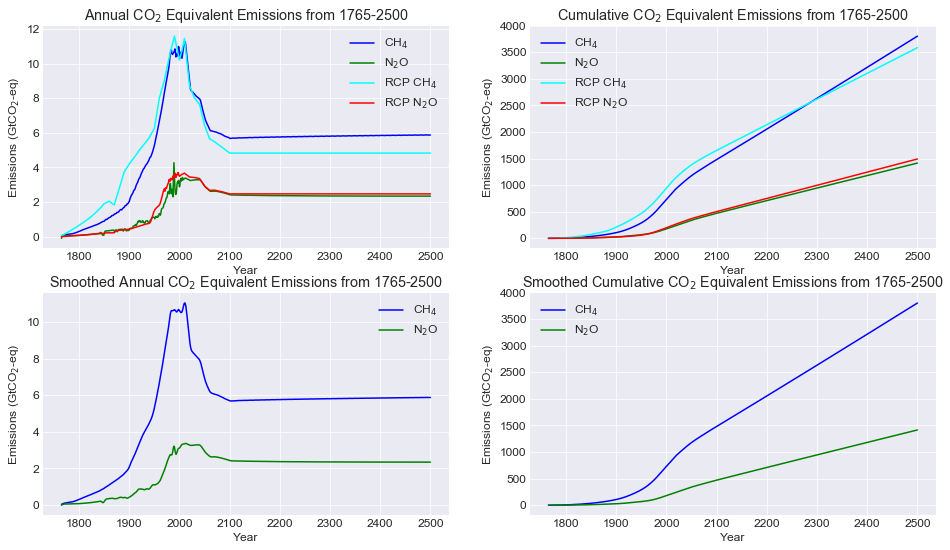

In [25]:
# Plotting

time = np.arange(1765,2501)

# RCP equivalent emissions for plotting
RCP_CH4eq = CH4GWP100 * M_emissions / 1000.0
RCP_N2Oeq = N2OGWP100 * N_emissions / 1000.0

#Cumulative emissions for plotting
cumCH4 = np.cumsum(CH4CO2eq)
cumN2O = np.cumsum(N2OCO2eq)

RCP_cumCH4 = np.cumsum(RCP_CH4eq)
RCP_cumN2O = np.cumsum(RCP_N2Oeq)

from scipy.ndimage.filters import gaussian_filter as smooth

CH4CO2eq_smooth = smooth(CH4CO2eq,2)
N2OCO2eq_smooth = smooth(N2OCO2eq,2)

cumCH4_smooth = np.cumsum(CH4CO2eq_smooth)
cumN2O_smooth = np.cumsum(N2OCO2eq_smooth)

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(time,CH4CO2eq,color='blue',label='CH$_4$')
ax1.plot(time,N2OCO2eq,color = 'green',label = 'N$_2$O')
ax1.plot(time,RCP_CH4eq,color = 'cyan',label='RCP CH$_4$')
ax1.plot(time,RCP_N2Oeq,color = 'red',label='RCP N$_2$O')
ax1.legend(loc='best')
ax1.set_xlabel("Year")
ax1.set_ylabel("Emissions (GtCO$_2$-eq)")
ax1.set_title("Annual CO$_2$ Equivalent Emissions from 1765-2500")

ax2.plot(time,cumCH4,color='blue',label='CH$_4$')
ax2.plot(time,cumN2O,color='green',label = 'N$_2$O')
ax2.plot(time,RCP_cumCH4,color = 'cyan',label='RCP CH$_4$')
ax2.plot(time,RCP_cumN2O,color = 'red',label='RCP N$_2$O')
ax2.legend(loc='best')
ax2.set_xlabel("Year")
ax2.set_ylabel("Emissions (GtCO$_2$-eq)")
ax2.set_title("Cumulative CO$_2$ Equivalent Emissions from 1765-2500")

ax3.plot(time,CH4CO2eq_smooth,color='blue',label='CH$_4$')
ax3.plot(time,N2OCO2eq_smooth,color = 'green',label = 'N$_2$O')
ax3.legend(loc='best')
ax3.set_xlabel("Year")
ax3.set_ylabel("Emissions (GtCO$_2$-eq)")
ax3.set_title("Smoothed Annual CO$_2$ Equivalent Emissions from 1765-2500")

ax4.plot(time,cumCH4_smooth,color='blue',label='CH$_4$')
ax4.plot(time,cumN2O_smooth,color='green',label = 'N$_2$O')
ax4.legend(loc='best')
ax4.set_xlabel("Year")
ax4.set_ylabel("Emissions (GtCO$_2$-eq)")
ax4.set_title("Smoothed Cumulative CO$_2$ Equivalent Emissions from 1765-2500")